# NumPyroによるベイズモデリング入門【線形回帰編】
https://deepblue-ts.co.jp/bayesian-statistics/numpyro-linear/

In [1]:
import warnings
warnings.filterwarnings('ignore')

- NumPyroはバックエンドがJaxでサポートされているGPU対応PPL（確率的プログラミング言語）
- マルコフ連鎖モンテカルロ（MCMC）法によるサンプリングが高速

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpyro
sns.set_style("darkgrid")

In [3]:
# GPUだとMCMC遅いのでcpu使う
numpyro.set_platform("cpu")

単回帰モデル~y=ax+b+ϵ（=Normal(a * x + b, ϵ)）をモデリングする

1. 回帰係数 ~ a、切片項 ~ b、観測の分散パラメータ~σを事前分布からサンプル
    - 3種のパラメータの事前分布は以下を仮定
        - a: Normal(0,100)
        - b: Normal(0,100)
        - σ: LogNormal(0,10)
2. それらと観測データのxであるx_i により確率モデルの形状を決定
3. 確率モデルから観測~y_i をサンプル
4. 2.3.をNN回繰り返す

In [4]:
def model(x, y, N=100):
    # 事後分布の形が正規分布とだとして
    # 回帰係数 a、切片項 b の事前分布に平均0, 分散100の正規分布を置きます。
    # jnp.arrayはnp.arrayのようなもの(jaxでのarray)
    a = numpyro.sample(
        "a", numpyro.distributions.Normal(loc=jnp.array(0.0), scale=jnp.array(100.0))
    )
    b = numpyro.sample(
        "b", numpyro.distributions.Normal(loc=jnp.array(0.0), scale=jnp.array(100.0))
    )
    # 分散パラメータ sigma の事前分布に平均0, 分散10の対数正規分布を置きます。
    sigma = numpyro.sample("sigma", numpyro.distributions.LogNormal(0, 10))
    
    # 観測についての確率モデルとして、正規分布を置きます。
    # yは実際に観測されているものなので、データyと観測モデルを紐づけるために、obs=yと設定しておきます
    # numpyro.plate は yi のように複数の確率変数をまとめて書くことができる便利な関数
    with numpyro.plate("data", N):
        numpyro.sample("obs", numpyro.distributions.Normal(a * x + b, sigma), obs=y)

model 使う前に yi∼Normal(−5x+3,1.0) でデータ生成してみる

推論結果として事後分布は、それぞれ a=−5, b=3, σ=1.0 あたりにピークが来るような分布であると嬉しい

今回はデータ数を 5, 10, 50 として、それぞれの挙動を確認

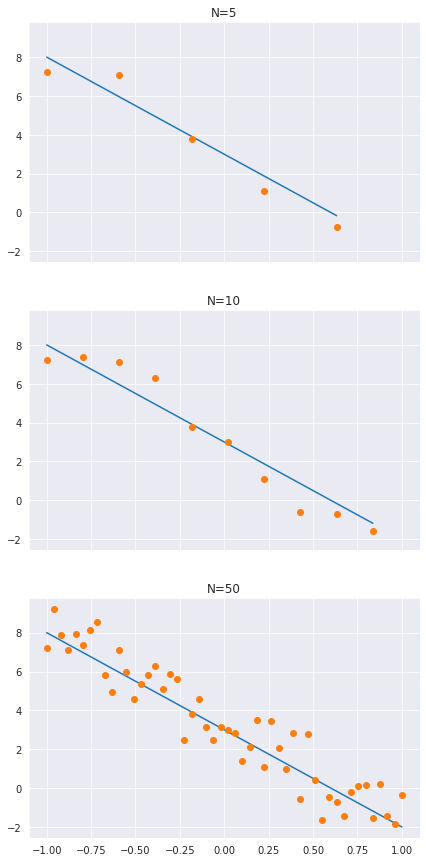

In [5]:
import random


def toy_data(a, b, N):
    x = np.linspace(-1, 1, N)
    y = a * x + b + 1.0 * jax.random.normal(jax.random.PRNGKey(1), x.shape)
    return x, y

def get_y_ture(x, a=-5, b=3):
    return a * x + b

x_data50, y_data50 = toy_data(-5, 3, 50)
x_data10, y_data10 = x_data50[np.arange(0, 50, 5)], y_data50[np.arange(0, 50, 5)]
x_data5, y_data5 = x_data50[np.arange(0, 50, 10)], y_data50[np.arange(0, 50, 10)]

fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(7, 15))

ax[0].plot(x_data5, [get_y_ture(x) for x in x_data5])
ax[0].plot(x_data5, y_data5, "o")
ax[0].set_title("N=5")

ax[1].plot(x_data10, [get_y_ture(x) for x in x_data10])
ax[1].plot(x_data10, y_data10, "o")
ax[1].set_title("N=10")

ax[2].plot(x_data50, [get_y_ture(x) for x in x_data50])
ax[2].plot(x_data50, y_data50, "o")
ax[2].set_title("N=50")

plt.show()

#### MCMCによるサンプリング

大抵の場合はこの事後分布を解析的に求めることができないので、事後分布を近似する変分ベイズ法や事後分布からサンプリングするMCMC法を用いて、事後分布を近似的に求めます

MCMCでは、事後分布 ~ p(a,b,σ∣X,Y)からたくさんサンプリングして、事後分布 ~ p(a,b,σ∣X,Y)の形状を知ろうとする

In [6]:
## おまじない
## num_warmup, num_samplesあたりは適切に設定する必要がありますが、この辺りは他のPPLと同様なので割愛します。
kernel = numpyro.infer.NUTS(model)  # モデルをNUTS（HMCの一種）にかける
mcmc5 = numpyro.infer.MCMC(kernel, num_warmup=300, num_samples=1000)
mcmc10 = numpyro.infer.MCMC(kernel, num_warmup=300, num_samples=1000)
mcmc50 = numpyro.infer.MCMC(kernel, num_warmup=300, num_samples=1000)

In [7]:
# サンプリング
## N=5の場合
mcmc5.run(jax.random.PRNGKey(1),x = x_data5, y = y_data5, N = x_data5.shape[0])
## N=10の場合
mcmc10.run(jax.random.PRNGKey(1),x = x_data10, y = y_data10, N = x_data10.shape[0])
## N=5の場合
mcmc50.run(jax.random.PRNGKey(1),x = x_data50, y = y_data50, N = x_data50.shape[0])

sample: 100%|███████████████████████████████████████| 1300/1300 [00:02<00:00, 607.01it/s, 7 steps of size 7.36e-01. acc. prob=0.92]


#### 結果
事後分布から得られたサンプリングを眺めてみましょう。

get_samples()を用いて、事後分布から各パラメータa,b,ϵをサンプリング

In [8]:
##N=5のとき
samples5 = mcmc5.get_samples()
a_samples5 = samples5["a"].squeeze()
b_samples5 = samples5["b"].squeeze()
sigma_samples5 = samples5["sigma"].squeeze()
##N=10のとき
samples10 = mcmc10.get_samples()
a_samples10 = samples10["a"].squeeze()
b_samples10 = samples10["b"].squeeze()
sigma_samples10 = samples10["sigma"].squeeze()
##N=50のとき
samples50 = mcmc50.get_samples()
a_samples50 = samples50["a"].squeeze()
b_samples50 = samples50["b"].squeeze()
sigma_samples50 = samples50["sigma"].squeeze()

print_summary()を用いると、主要な統計量を見ることが出来る
- https://zenn.dev/kajyuuen/articles/c89a9ca9a2d2f87a209e

In [9]:
mcmc5.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -5.28      1.20     -5.35     -6.81     -3.51    250.93      1.01
         b      2.76      0.72      2.71      1.63      3.79    192.03      1.01
     sigma      1.22      0.75      1.02      0.43      2.04    170.30      1.00

Number of divergences: 0


In [10]:
mcmc10.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -5.63      0.51     -5.65     -6.48     -4.85    541.89      1.01
         b      2.84      0.32      2.84      2.37      3.35    603.83      1.00
     sigma      0.91      0.27      0.86      0.55      1.30    463.30      1.00

Number of divergences: 0


In [11]:
mcmc50.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -5.05      0.24     -5.04     -5.46     -4.67    591.84      1.00
         b      3.25      0.15      3.26      3.01      3.48   1474.60      1.00
     sigma      1.05      0.11      1.04      0.88      1.22    630.83      1.00

Number of divergences: 0


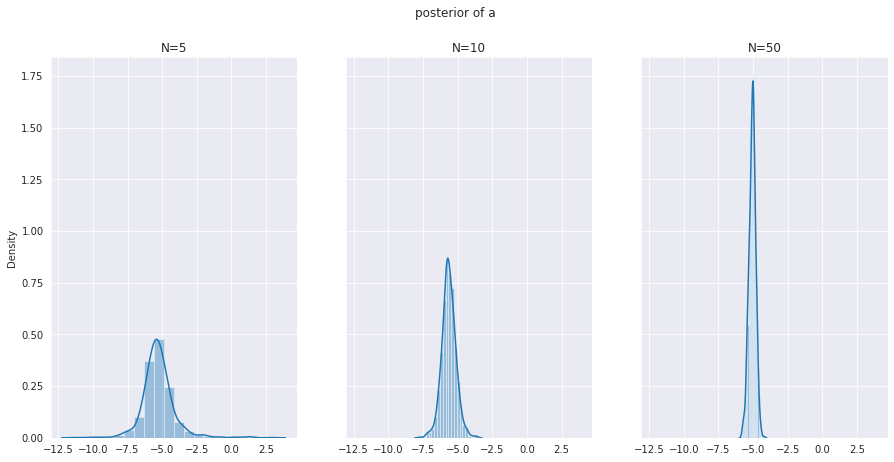

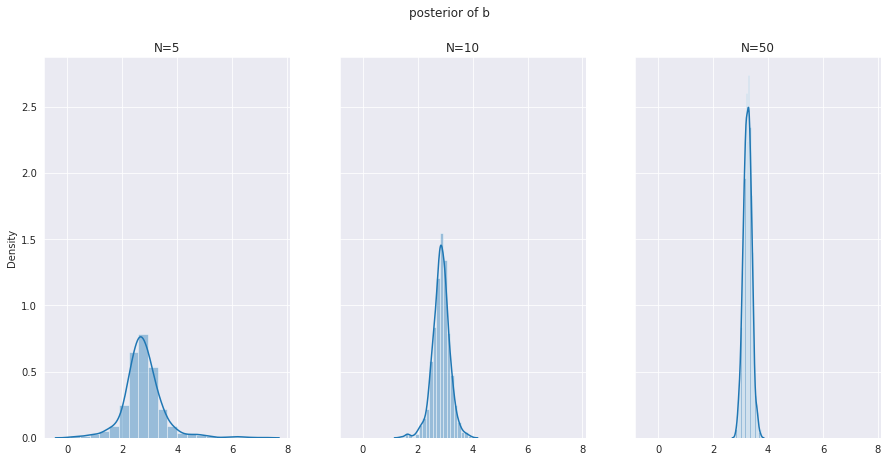

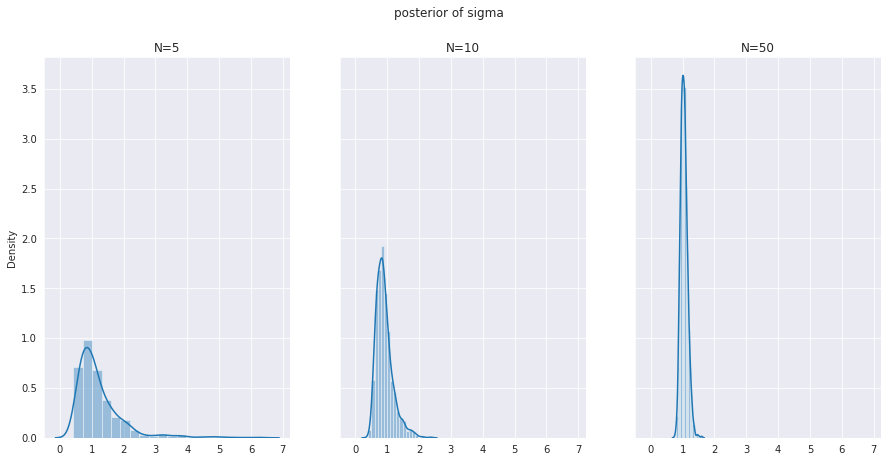

In [12]:
##aについて
fig1, ax1 = plt.subplots(1,3,figsize=(15,7),sharey=True,sharex=True)
sns.distplot(a_samples5, bins=20, ax=ax1[0]).set_title("N=5")
sns.distplot(a_samples10, bins=20, ax=ax1[1]).set_title("N=10")
sns.distplot(a_samples50, bins=20, ax=ax1[2]).set_title("N=50")
fig1.suptitle("posterior of a")
##bについて
fig2, ax2 = plt.subplots(1,3,figsize=(15,7),sharey=True,sharex=True)
sns.distplot(b_samples5, bins=20, ax=ax2[0]).set_title("N=5")
sns.distplot(b_samples10, bins=20, ax=ax2[1]).set_title("N=10")
sns.distplot(b_samples50, bins=20, ax=ax2[2]).set_title("N=50")
fig2.suptitle("posterior of b")
##sigmaについて
fig3, ax3 = plt.subplots(1,3,figsize=(15,7),sharey=True,sharex=True)
sns.distplot(sigma_samples5, bins=20, ax=ax3[0]).set_title("N=5")
sns.distplot(sigma_samples10, bins=20, ax=ax3[1]).set_title("N=10")
sns.distplot(sigma_samples50, bins=20, ax=ax3[2]).set_title("N=50")
fig3.suptitle("posterior of sigma")
plt.show()

だいたい真値 a=−5,b=3,σ=0.5 あたりにピークを持つ事後分布になっています。

また、データを増やすほど、不確実性が小さくなっている様子が見て取れるます。

ただ、データが少なくてもまあまあいい結果にはなっていますね。

#### 事後分布からのサンプリングを元に予測分布を生成

In [13]:
# 予測分布の計算にはnumpyro.infer.Predictiveを使います。
predictive5 = numpyro.infer.Predictive(model, samples5)
predictive10 = numpyro.infer.Predictive(model, samples10)
predictive50 = numpyro.infer.Predictive(model, samples50)

In [14]:
index_points = np.linspace(-2., 2., 2000)
predictive_samples5 = predictive5(
    jax.random.PRNGKey(1),
    index_points,
    None,
    index_points.shape[0])["obs"]
predictive_samples10 = predictive10(
    jax.random.PRNGKey(1),
    index_points,
    None,
    index_points.shape[0])["obs"]
predictive_samples50 = predictive50(
    jax.random.PRNGKey(1),
    index_points,
    None,
    index_points.shape[0])["obs"]

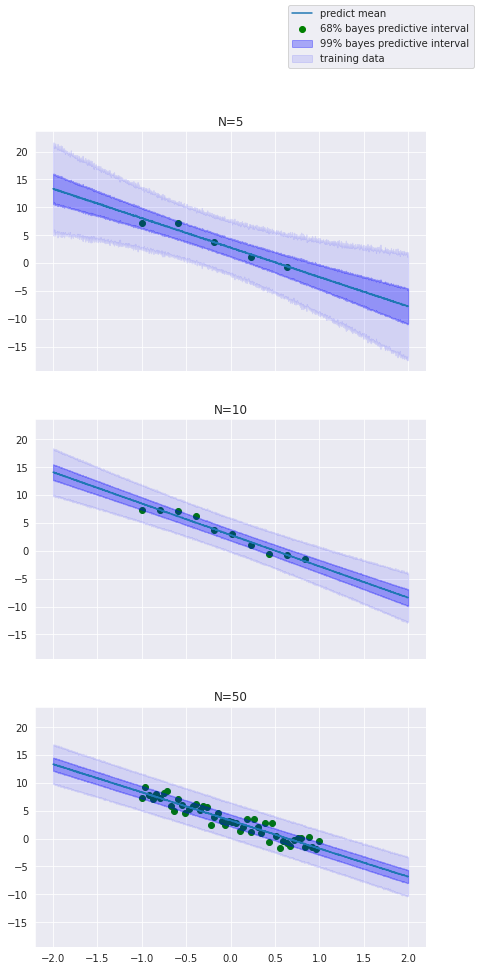

In [15]:
mean5 = predictive_samples5.mean(axis=0)
mean10 = predictive_samples10.mean(axis=0)
mean50 = predictive_samples50.mean(axis=0)
std5 = predictive_samples5.std(axis=0)
std10 = predictive_samples10.std(axis=0)
std50 = predictive_samples50.std(axis=0)
lower5_1, upper5_1 = mean5 - std5, mean5 + std5
lower10_1, upper10_1 = mean10 - std10, mean10 + std10
lower50_1, upper50_1 = mean50 - std50, mean50 + std50
lower5_3, upper5_3 = mean5 - 3*std5, mean5 + 3*std5
lower10_3, upper10_3 = mean10 - 3*std10, mean10 + 3*std10
lower50_3, upper50_3 = mean50 - 3*std50, mean50 + 3*std50
fig, ax = plt.subplots(3,1,sharex=True,sharey=True,figsize=(7,15))
ax[0].scatter(x_data5, y_data5, color="g")
ax[0].plot(index_points, mean5)
ax[0].fill_between(index_points.squeeze(), lower5_1, upper5_1, alpha=0.3, color="b")
ax[0].fill_between(index_points.squeeze(), lower5_3, upper5_3, alpha=0.1, color="b")
ax[0].set_title("N=5")
ax[1].scatter(x_data10, y_data10, color="g")
ax[1].plot(index_points, mean10)
ax[1].fill_between(index_points.squeeze(), lower10_1, upper10_1, alpha=0.3, color="b")
ax[1].fill_between(index_points.squeeze(), lower10_3, upper10_3, alpha=0.1, color="b")
ax[1].set_title("N=10")
ax[2].scatter(x_data50, y_data50, color="g")
ax[2].plot(index_points, mean50)
ax[2].fill_between(index_points.squeeze(), lower50_1, upper50_1, alpha=0.3, color="b")
ax[2].fill_between(index_points.squeeze(), lower50_3, upper50_3, alpha=0.1, color="b")
ax[2].set_title("N=50")
fig.legend(["predict mean",
            "68% bayes predictive interval",
            "99% bayes predictive interval",
            "training data"])
plt.show()